In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from dm_control import mjcf
from typing import Tuple
from tqdm import trange
from pathlib import Path

from flygym.arena import BaseArena
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
from flygym.util.config import all_leg_dofs, all_leg_dofs
from flygym.util.vision import visualize_visual_input

In [3]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

# Load recorded data
data_path = Path(pkg_resources.resource_filename("flygym", "data"))
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [4]:
# Visualize camera views during simulation
sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.1,
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    draw_markers=True,
)
obs_list = []
for i in trange(50):
    joint_pos = data_block[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
    obs_list.append(obs)
nmf.close()

100%|██████████| 50/50 [00:00<00:00, 206.20it/s]


In [5]:
img_45 = nmf.physics.render(720, 720, camera_id="Animat/camera_head_zoomin")
img_front = nmf.physics.render(720, 720, camera_id="Animat/camera_front_zoomin")

(-0.5, 719.5, 719.5, -0.5)

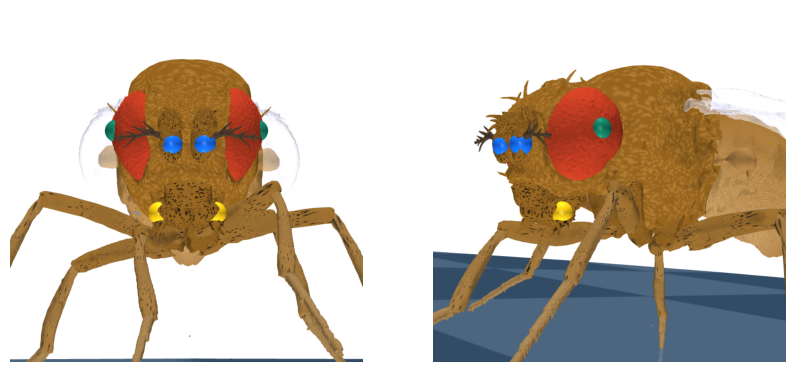

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_front)
axs[0].axis("off")
axs[1].imshow(img_45)
axs[1].axis("off")